<img style="float: left; width: 120px; padding-right: 25px;" src="PSLogo.jpg">

<span style="font-family:Futura Next; font-size:2.5em; float: left;">Making fairness an intrinsic part of AI for FS</span>

----

<p class='lead'> What is the session about </p>

The suitability of Machine Learning models is traditionally measured on its accuracy. A highly accurate model based on metrics like RMSE, MAPE, AUC, ROC, Gini, etc are considered to be high performing models. While such accuracy metrics important, are there other metrics that the data science community has been ignoring so far? The answer is yes—in the pursuit of accuracy, most models sacrifice “fairness” and “interpretability.” Rarely, a data scientist tries to dissect a model to find out if the model follows all ethical norms. This is where machine learning fairness and interpretability of models come into being.

There have been multiple instances when an ML model was found to discriminate against a particular section of society, be it rejecting female candidates during hiring, systemically disapproving loans to working women, or having a high rejection rate for darker color candidates. 

Certain people are from protected categories. For instance, if a business differentiates against a person solely due to the fact that they are a person of color, it would be considered unethical and illegal. However, some ML models in banks today do exactly that, by having a feature encoding the race of each applicant. This is against the concept of fairness.

Machine Learning, as the name implies, learns whatever it is taught. It’s a ramification of what it is fed. It’s a fallacy that ML doesn’t have perspective; it has the same perspective that the data has, which was used to make it learn what it preaches today. In simple words, algorithms can echo prejudices that data explicitly or implicitly have.

*It’s important for an organisation to ensure models are fair and accountable. The first step towards this would be to understand the distribution of sensitive features (like age, gender, color, race, nationality) to the outcome features (default, reject, approve, high rate, etc).*

In order to ensure fairness of models, some key metrics need to be defined. While there are many possible fairness metrics, the most important are **Statistical Parity and Disparate Impact** which can be used to quantify and measure bias or discrimination.

----

<p class='lead'> Fair ML Lifecycle </p>
<img style="width: 9000px; padding-right: 15px;" src="FairML LC.png">

----

<p class='lead'> About the data </p>

The [data-set](https://www.bondora.com/marketing/media/LoanData.zip) has data about 29688 loans and 172 columns or features (depending which parlance you prefer).
The prediction model can predict two types of outcomes - categorical (yes/no, true/false classes) or numerical (one is less than one hundred).  
**The definition of “good” class is straight forward - the class in which you are willing to invest or give a credit, but “bad” class definition may be bit complicated.**  
The data-set has data about the borrowers who were late with their payments for 7, 14, 21, 60 days and defaulted loans. How bad is a borrower if he is late for X days? True, he doesn’t respect the schedule and the contract for various reason such as harsh life, distraction or any other reason. However, once he is back on track he pays what he owns, plus late charges, which leads to higher return for additional risk.  

The defaulted loans really sounds as bad loans, right? Well, what if the loan defaults, but you get back the principal and partial interest rate? Doesn’t sound that bad, does it? What you really don’t like is the default on the loan and zero payments - these loans are the fraud and you want to avoid them. So let’s mark them as a “bad” ones.
After initial cleaning of the data-set and feature engineering it was time to build a simple model. 

In a classification task, precision and recall are used frequently for model metrics. The predicted value can be assigned to four classes: True Positive - real fraud (model predicted True and value was True), True Negative - not a fraud (model predicted False value and value was False), False Positive - not fraud marked as a fraud (model predicted True, however value was False) and False Negative - real fraud marked as not fraud (model predicted False, but the value was True).  
The data set after cleaning and feature transformation will be having the following list of features:

- CreditScoreEeMini
- CreditScoreEsEquifaxRisk
- CreditScoreEsMicroL
- CreditScoreFiAsiakasTietoRiskGrade
- Education
- EmploymentDurationCurrentEmployer
- EmploymentStatus
- Gender
- HomeOwnershipType
- LanguageCode
- MaritalStatus
- MonthlyPaymentDay
- NewCreditCustomer
- OccupationArea
- Rating
- UseOfLoan
- VerificationType
- NrOfDependants
- WorkExperience
- IncomeOther
- IncomeTotal
- Interest 
- LoanDuration 
- LossGivenDefault
- MonthlyPayment
- ProbabilityOfDefault 
- NrOfDependantslessthan3 
- WrExLess10 
- WrExLess5 
- Tenant
- Default


----

<a id="TOC"> </a> <p class='lead'> Content </p>

1. [Loading libraries](#1)  
2. [Loading and preparing the data](#2)  
3. [Exploring data](#3)  
4. [Data bias detection](#4)  
5. [Removing bias from data using reweighing technique](#5)
    1. [Model development with and without weights](#5a)
    2. [Fairness metrics post model training](#5b)
6. [Accuracy-cost-fairness trade-off](#6)
    1. [Calibrating across single threshold](#6a)  
    2. [Calibrating across different threshold for two groups](#6b)  
7. [Additive counterfactual fair model](#8)
    1. [Classification (multiple protected features)](#8a)
    2. [Regression (multiple protected features)](#8b)
8. [Get in touch](#gt)


----

<a id="1"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading libraries</span>
</div>

In [2]:
import logging
import numpy
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading and preparing the data</span>
</div>

In [3]:
datafile = pd.read_csv('LoanEE2.csv')

In [4]:
def _prepare_data(df_):
    df_["Defaulted"] = df_['DefaultDate'].apply(lambda x: 0 if pd.isnull(x) else 1)
    df_["PaidLoan"] = df_["Defaulted"].replace({0: 1, 1: 0})
    df_["Default"] = df_["PaidLoan"].apply(lambda x: 0 if x == 1 else 1)
    
    
    return DataTransformer.transform(df_) #, pd.isnull(data.DefaultDate)


In [5]:
input_data = _prepare_data(datafile)

In [6]:
data=input_data

Creating a few feature based on Age

In [7]:
data["Young"] = data["Age"].apply(lambda x: "1" if x < 40 else "0")

In [8]:
data["Young"]=data["Young"].astype(str).astype(int)

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="3"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Exploring data</span>
</div>

In [9]:
data.shape

(61321, 205)

In [10]:
data["Default"].value_counts()

0.0    46752
1.0    14569
Name: Default, dtype: int64

<div class="alert alert-block alert-success">
<b>Inference:</b>
We can infer that the data has more 0's (False) when it comes to defaulter compared to 1's (True).  
Thus there are more non-defaulters than defaulters.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

---

<a id="4"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Data bias detection</span>
</div>

<p class='lead'> Definition: </p>

- **Protected group** is a feature $\mathbf{S}$ that belongs to $\mathbf{X}$ having  $\mathbf{N}$ data points and ${D}$ dimensions
- **Advantegous group / Privileged** is a level $\mathbf{T}_{a}$ of the feature $\mathbf{S}$ having $\mathbf{N}_{a}$ data points belonging to $\mathbf{X}$ having a higher probability of favourable outcome and is also called $\mathbf{S}=1$. Also $\mathbf{S_a}$
- **Disadvantegous group / Unprivileged** is a level $\mathbf{T}_{d}$ of the feature  $\mathbf{S}$ having $\mathbf{N}_{d}$ data points belonging to X which has a higher probability of favourable outcome and is also called $\mathbf{S}=0$. Also $\mathbf{S_d}$
- **Actual lables / target** with data point $\mathbf{N}$ are represnted by $\mathbf{Y}$ having values ${y}$
- **Predicted labels** are represented $\hat{Y}$

### Statistical Parity Difference and Disparate Impact  
**Probability of all groups under protected class to have same probablity of favourable outcome**  
[Fairness Through Awareness](https://arxiv.org/pdf/1104.3913.pdf)

**Statistical Parity Difference:**
$$
\begin{align}
\mathbb{P}({Y} = 1 {|} \mathbf{S} = \mathbf{T}_{a}) = \mathbb{P}( {Y}=1{|}\mathbf{S} = \mathbf{T}_{d})
\end{align}
$$

**Disparate Impact:**


$$
\begin{align}
\frac{\mathbb{P}(Y=1{|}S=T_a)} {\mathbb{P}(Y=1{|}S=T_a)}
\end{align}
$$

In [11]:
#0 if favourable [false, default = false]
#1 if unfavourable [true, default = True]
fav=0
unfav=int(not fav)

In [12]:
a='Gender_0.0' #Male
b='Education_5.0' #Higher Ed
c='Young' # Age group
d='HomeOwnershipType_1.0' #Owner 
e='HomeOwnershipType_8.0' #Mortgages
f='EmploymentStatus_5.0' #Entrepreneur
g="Tenant" #Tenant

i='LanguageCode_1' #Estonian
j='LanguageCode_2' #English
k="NrOfDependantslessthan3" #No of dependent less than 10 years
l='MaritalStatus_1.0' #Married
m='MaritalStatus_3.0' #Single
n='MaritalStatus_4.0' #Divorced

p="WrExLess10" #Work ex less than 10 years
q="WrExLess5" #Work ex less than 5 years


In [13]:
label_names=['Default']

protected_attribute_names=[a,b,c,d,e,f,g,i,j,k,l,m,n,p,q]

#privileged_groups = [{b: 1}, {c:1}, {d:1}, {e: 1}, {g:1}, {h: 1}, {i:1}, {f:1}, {k:1}] #Male
privileged_groups = [{a :0}, {b :0}, {c :0}, {d :0}, {e :0}, {f :0}, 
                        {g :0}, {i :0}, {j :0}, {k :0}, 
                        {l :0}, {m :0}, {n:0}, {p :0}, {q :0}]



#unprivileged_groups = [{b: 0}, {c:0}, {d:0}, {e: 0}, {g:0}, {h: 0}, {i:0}, {f:0}, {k:0}] #Female


unprivileged_groups = [{a :1}, {b :1}, {c :1}, {d :1}, {e :1}, {f :1}, 
                        {g :1}, {i :1}, {j :1}, {k :1}, 
                        {l :1}, {m :1}, {n:1}, {p :1}, {q :1}]


input_dataframe = data.copy()
INPUT_DATAFRAME = input_dataframe
LABEL_NAMES = label_names
PROTECTED_ATTRIBUTE_NAMES = protected_attribute_names
PRIVILEGED_GROUPS = privileged_groups
UNPRIVILEGED_GROUP = unprivileged_groups


SP=[]
DI=[]
Protected=[]
for groupe in range(0, len(protected_attribute_names)):
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    privileged_group_protected_attribute_value = PRIVILEGED_GROUPS[groupe][protected_attribute_name]
    unprivileged_group_protected_attribute_value = UNPRIVILEGED_GROUP[groupe][protected_attribute_name]
    print(protected_attribute_name, privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    stat_parity, disprate_impact = stat_parity_test(data, protected_attribute_name, 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    SP.append(stat_parity)
    DI.append(disprate_impact)
    Protected.append(protected_attribute_name)
    
    print ("")

Gender_0.0 0 1
Statistical Parity Difference 0.0659878494069962
Disparate Impact 1.0924819563899022

Education_5.0 0 1
Statistical Parity Difference 0.060003289360061496
Disparate Impact 1.0801386554367447

Young 0 1
Statistical Parity Difference -0.07241068853497912
Disparate Impact 0.9098162947410234

HomeOwnershipType_1.0 0 1
Statistical Parity Difference 0.03308219776293675
Disparate Impact 1.0441758557196397

HomeOwnershipType_8.0 0 1
Statistical Parity Difference 0.10150342452057504
Disparate Impact 1.134839797576764

EmploymentStatus_5.0 0 1
Statistical Parity Difference -0.08650158252530704
Disparate Impact 0.8868813799464257

Tenant 0 1
Statistical Parity Difference -0.0573416833805781
Disparate Impact 0.9259271443038499

LanguageCode_1 0 1
Statistical Parity Difference 0.03872787648108733
Disparate Impact 1.0530500032910963

LanguageCode_2 0 1
Statistical Parity Difference -0.04328406445997812
Disparate Impact 0.9432495336719515

NrOfDependantslessthan3 0 1
Statistical Parity

<div class="alert alert-block alert-info">
<b>Remember:</b> 

- Statistical Parity Difference should be between -0.1 and 0.1
- Disparate Impact should be between 0.90 and 1.10
- Negative sign shows that: the unprivileged group is worse in favourable outcome that privileged class (as the formula used it probability of unprivileged - probablity of privileged), so in case you see a positive value, you may want to reconsider your choice of privileged and unprivileged groups <b>using the next two plots</b>
</div>


In [13]:
SP, DI, Protected
d = pd.DataFrame({'Protected_feature':Protected,'Statistical_Parity':SP,'Disparate_Impact':DI})
d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)
#d

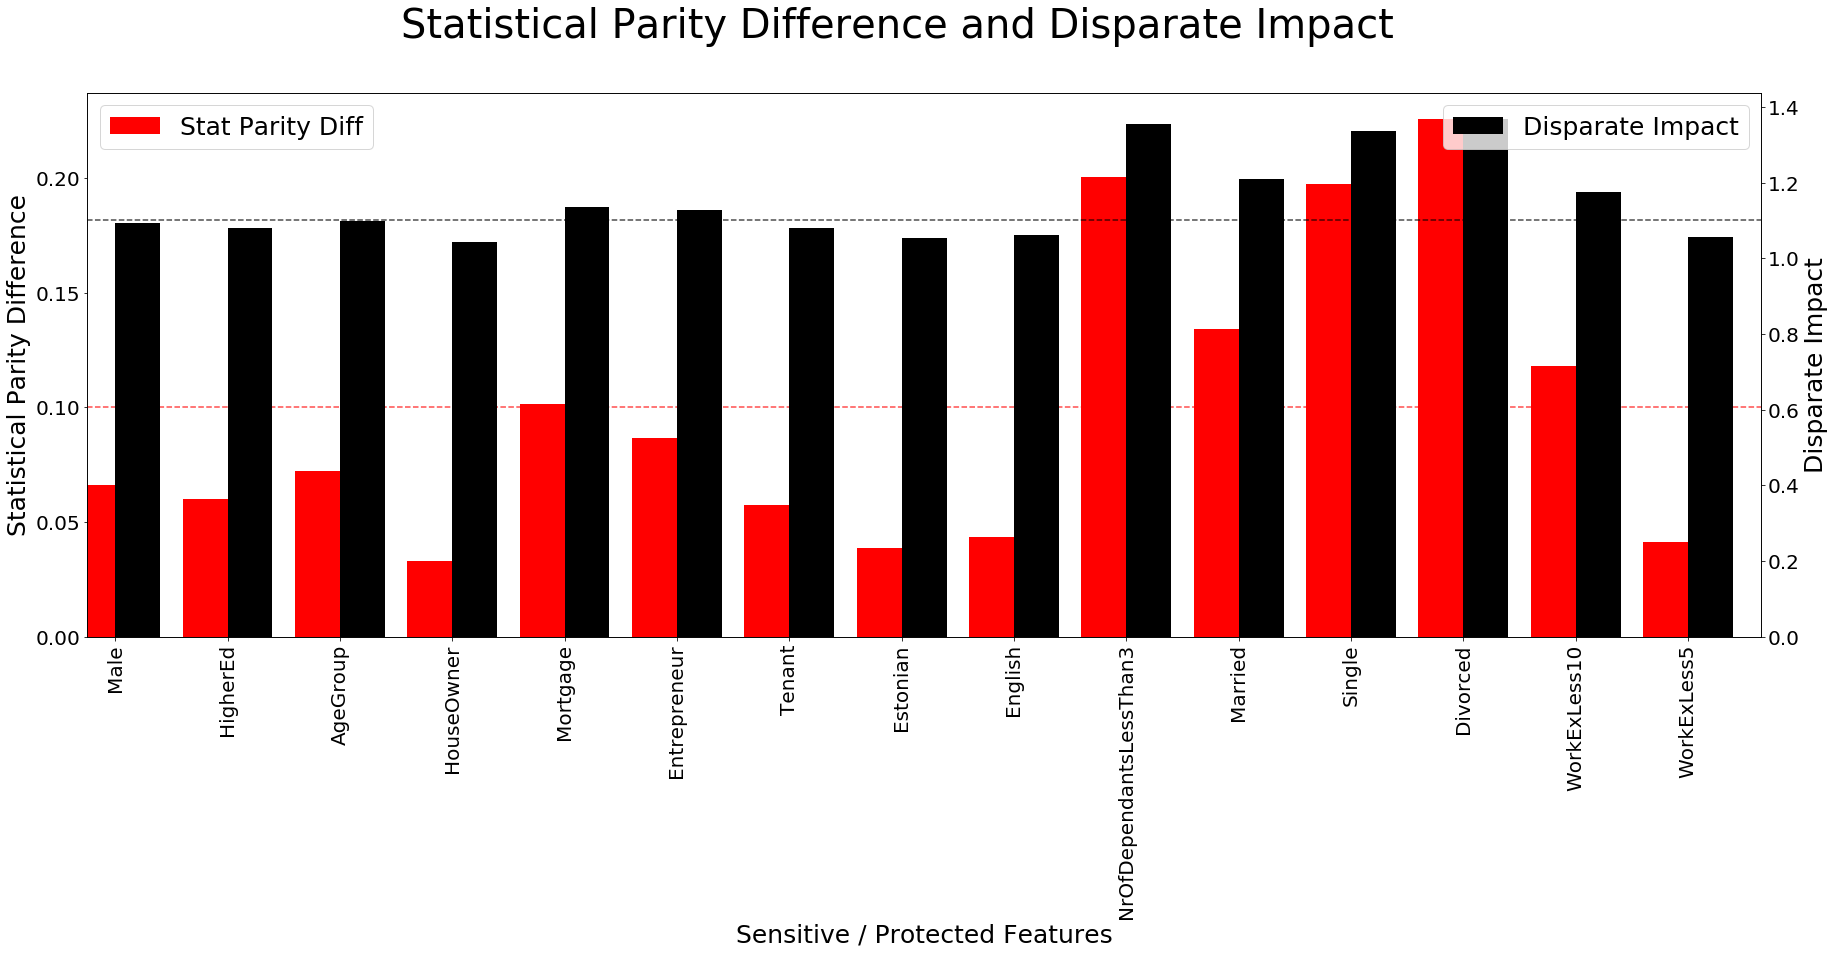

In [14]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.


fig.suptitle('Statistical Parity Difference and Disparate Impact', fontsize=40, y=1)


width = 0.4
d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
       position=1, color='red', legend=False, figsize=(30,10), fontsize=20)

d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
       position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

ax.axhline(y=0.1, linestyle='dashed', alpha=0.7, color='red')
ax2.axhline(y=1.10, linestyle='dashed', alpha=0.7, color='black')


patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)



labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Male'
labels[1] = 'HigherEd'
labels[2] = 'AgeGroup'
labels[3] = 'HouseOwner'
labels[4] = 'Mortgage'
labels[5] = 'Entrepreneur'
labels[6] = 'Tenant'
labels[7] = 'Estonian'
labels[8] = 'English'
labels[9] = 'NrOfDependantsLessThan3'
labels[10] = 'Married'
labels[11] = 'Single'
labels[12] = 'Divorced'
labels[13] = 'WorkExLess10'
labels[14] = 'WorkExLess5'

ax.set_xticklabels(labels)


#ax2.axhline(y=.80, linestyle='dashed', alpha=0.7, color='black')

ax.set_xlabel('Sensitive / Protected Features', fontsize=25)

ax.set_ylabel('Statistical Parity Difference', fontsize=25)
ax2.set_ylabel('Disparate Impact', fontsize=25)

plt.show()

#fig.savefig('SPDnDI.svg', format='svg', dpi=500, bbox_inches='tight')
#fig.savefig('SPDnDI.png', format='png', dpi=500, bbox_inches='tight')
#beingsaved = plt.figure()
#beingsaved.savefig('SPDnDI.eps', format='eps', dpi=500)




<div class="alert alert-block alert-success">
<b>Inference:</b>
It's clearly visible that 5 sensitive features (NrOfDependantslessthan3, Married, Single, Divorced and WorkExLess10) are having bias as per Statistical Parity Difference and Disparate Impact
</div>

### Frequency for sensitive features

In [15]:
for groupe in range(0, len(protected_attribute_names)):
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #print(protected_attribute_name)
    #print(data[protected_attribute_name].value_counts())
    #print ("-------------------------------------")

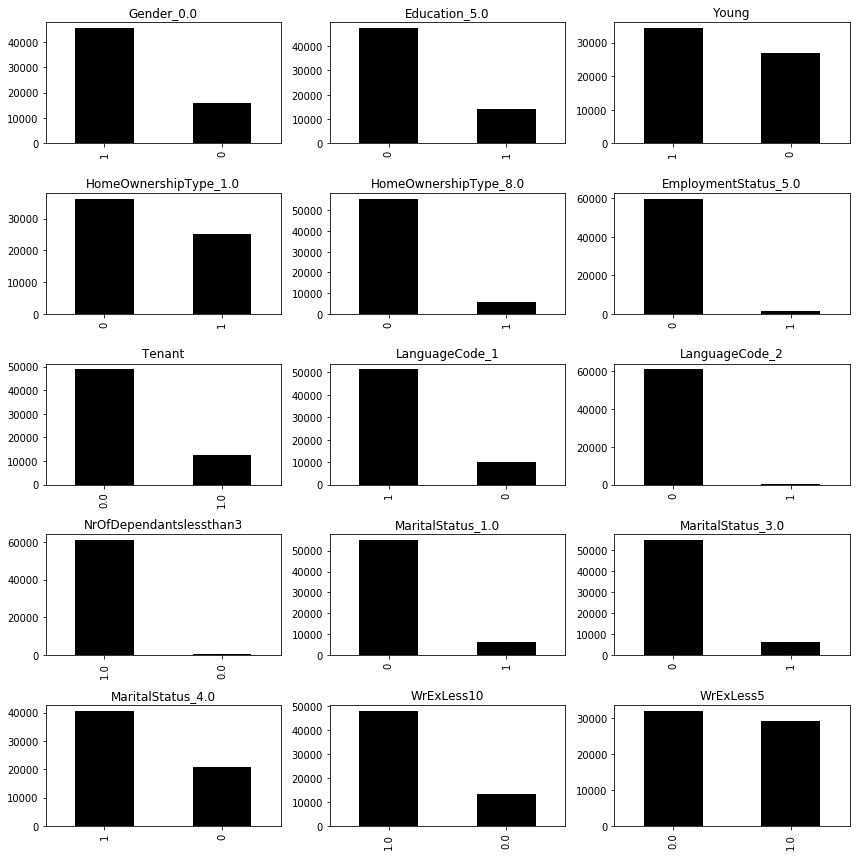

In [16]:
fig = plt.figure()

#ax = sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5)
#ax.set_title("Frequency of each sensitive features", fontsize=15) # fontweight="bold"



for groupe in range(0, len(protected_attribute_names)):
    #plt.figure(figsize = (4,2))
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #data[protected_attribute_name].value_counts().plot(kind='bar')
    ax = fig.add_subplot(5,3,groupe+1)

    
    vc=data[protected_attribute_name].value_counts()
    ax=vc.plot(kind='bar', figsize=(12,12), title=protected_attribute_name, color = 'black')
    #axes.plot(vc)


plt.tight_layout()
plt.show()

### Cross-tabs for sensitive features

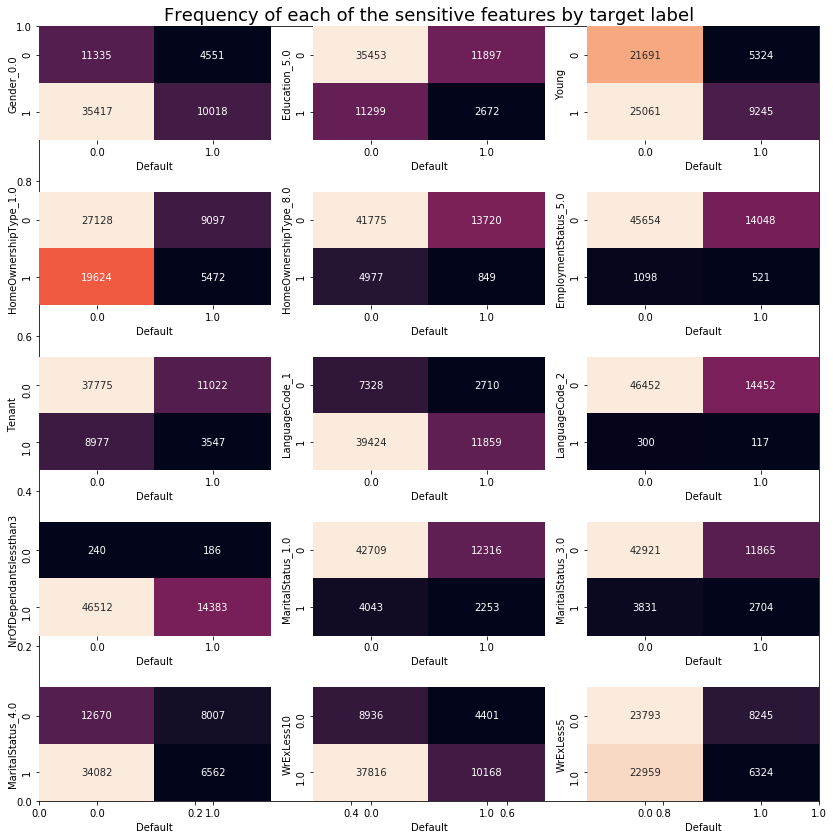

In [17]:
#fig = plt.figure()
fig, ax = plt.subplots(figsize=(12,12))
#plt.suptitle('lalala')
ax.set_title("Frequency of each of the sensitive features by target label", fontsize=18)


for groupe in range(0, len(protected_attribute_names)):
    #_,ax = plt.figure(figsize = (8,8))
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #data[protected_attribute_name].value_counts().plot(kind='bar')
    ax = fig.add_subplot(5,3,groupe+1)

    plotdf=pd.crosstab(data[protected_attribute_name], data['Default'])
    ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, ax=ax)    #axes.plot(vc)
    #print (type(axes))


plt.tight_layout()
plt.show()

### Calculation for Statistical Parity and Disparate Impact for a given protected feature
**Declaring the protected feature (a.k.a sensitive feature) and privileged & unprivileged groups**  
Here we are trying to find bias on basis of a sensitive feature (that explains if the customer is Married or Otherwise)

In [18]:
choice = 'MaritalStatus_1.0'
pval = 0 #privileged : see the above heatmaps
upval = int(not pval) #Unprivileged
#['HomeOwnershipType_8.0', 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'WrExLess10']

In [19]:
label_names=['Default']
protected_attribute_names=[choice]
privileged_groups=[{choice: pval}]
unprivileged_groups=[{choice: upval }]

In [20]:
input_dataframe = data
INPUT_DATAFRAME = input_dataframe

LABEL_NAMES = label_names
PROTECTED_ATTRIBUTE_NAMES = protected_attribute_names
PRIVILEGED_GROUPS = privileged_groups
UNPRIVILEGED_GROUP = unprivileged_groups

**Extracting the key and value from declared dictionary**

In [21]:
protected_attribute_name = list(UNPRIVILEGED_GROUP[0].keys())[0]
privileged_group_protected_attribute_value = PRIVILEGED_GROUPS[0][protected_attribute_name]
unprivileged_group_protected_attribute_value = UNPRIVILEGED_GROUP[0][protected_attribute_name]

**Calculating Statistical Parity and Disparate Impact scores**

In [22]:
stat_parity, disprate_impact = stat_parity_test(data, protected_attribute_name, 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)


Statistical Parity Difference -0.1340207177400593
Disparate Impact 0.8273317100927963


<div class="alert alert-block alert-success">
<b>Inference:</b> 
The Statistical Parity Difference for sensitive feature Married is more than -0.10 and Disparate Impact is less than 0.90, thus there can be traces fo bias in the data. This needs further investigation. Furthermore, the negative sign shows that the unprivileged group is worse in favourable outcome that privileged class (as the formula used it probablity of unprivileged - probability of privileged)
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b> 

- Statistical Parity Difference should be between -0.1 and 0.1
- Disparate Impact should be between 0.90 and 1.10
</div>




<span style="float:right;"> [TOC](#TOC) </span>

---

<a id="5"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Removing bias from data using reweighing technique</span>
</div>

[**Reweighing**](https://link.springer.com/content/pdf/10.1007%2Fs10115-011-0463-8.pdf)

The tuples in the training dataset are assigned weights. By carefully choosing the weights, the training dataset can be made discrimination-free w.r.t. ${S}$ without having to change any of the labels. The weights on the tuples can be used directly. 

*Note: Basic t-test that will reveal bias is the two-sample t test*

**Discrimination:** 

$$
\begin{align}
\frac{(X_{S}=advantageous | X_{Class}=positive)}{X_{S}=advantageous} - \frac{(X_{S}= disadvantageous | X_{Class}=positive)}{X_{S}= disadvantageous}
\end{align}
$$


**Weight:**
$$
\begin{align}
\frac{P_{expected}(S=X_{S} \ and \ Class=X_{Class})}{P_{observed}(S=X_{S} \ and \ Class=X_{Class})}
\end{align}
$$

Thus, there will be four categories of weights when:


- $X_{S}$ = advantageous, $X_{Class}$ = positive [Privileged and favourable]
- $X_{S}$ = advantageous, $X_{Class}$ = negative [Privileged and unfavourable]
- $X_{S}$ = disadvantageous, $X_{Class}$ = positive [Unprivileged and favourable]
- $X_{S}$ = disadvantageous, $X_{Class}$ = negative [Unprivileged and unfavourable]

<div class="alert alert-block alert-info">
<b>Remember:</b> 
Reweighing is one of those methods that has zero or less trade-off on accurcay of the algorithm. It can be also used for multi-class target variable and multi-level sensitive feature. Furthermore, it can be used for all types of supervised learning algorithms
</div>

In [23]:
PRIVILEGED_GROUPS
UNPRIVILEGED_GROUP

instance_weight = np.repeat(1, len(data)) 
data['instance_weights']=instance_weight

In [24]:
n = np.sum(data['instance_weights']) #Total number of instances


In [25]:
n_p = np.sum(data['instance_weights'][data[choice]==pval]) #Total number of privileged
n_up = np.sum(data['instance_weights'][data[choice]==upval]) #Total number of unprivileged


In [26]:
n_fav = np.sum(data['instance_weights'][data['Default']==0]) #Total number of favourable
n_unfav = np.sum(data['instance_weights'][data['Default']==1]) #Total number of unfavourable

In [27]:
n_p_fav=data[(data[choice]==pval)&(data['Default']==0)] 
n_p_unfav=data[(data[choice]==pval)&(data['Default']==1)] 
n_up_fav=data[(data[choice]==upval)&(data['Default']==0)] 
n_up_unfav=data[(data[choice]==upval)&(data['Default']==1)] 

w_n_p_fav = np.sum(n_p_fav['instance_weights']) #Total number of privileged and favourable
w_n_p_unfav = np.sum(n_p_unfav['instance_weights']) #Total number of privileged and unfavourable
w_n_up_fav = np.sum(n_up_fav['instance_weights']) #Total number of unprivileged and favourable
w_n_up_unfav = np.sum(n_up_unfav['instance_weights']) #Total number of unprivileged and unfavourable

In [28]:
w_n_p_fav, w_n_p_unfav, w_n_up_fav, w_n_up_unfav #No of instances per combination

(42709, 12316, 4043, 2253)

**Calculating weights**

**For instance:**
$$
\begin{align}
Weight_{P+F} = \frac{\mathbb{P}(Expected_{P+F})}{ \mathbb{P}(Observed_{P+F})}\\ \\
\mathbb{P}_{Expected} = \frac{Favourable}{n} * \frac{Privileged}{n} \\ \\
\mathbb{P}_{Observed} = \frac{Privileged \ and \ Favourable}{n}\\ \\
Weight_{P+F} = \frac{\frac{Favourable * Privileged} {n^2}}{ \frac{Privileged \ and \ Favourable}{n}}\\ \\
Weight_{P+F} = \frac{Favourable * Privileged} {Privileged \ and \ Favourable * n}\\ \\
\end{align}
$$


In [29]:
w_p_fav = (n_fav*n_p) / (n*w_n_p_fav)
w_p_unfav = (n_unfav*n_p) / (n*w_n_p_unfav)
w_up_fav = (n_fav*n_up) / (n*w_n_up_fav)
w_up_unfav = (n_unfav*n_up) / (n*w_n_up_unfav)

w_p_fav, w_p_unfav, w_up_fav, w_up_unfav

(0.9822716597371903, 1.061477726882457, 1.1872766965828196, 0.6639326745298092)

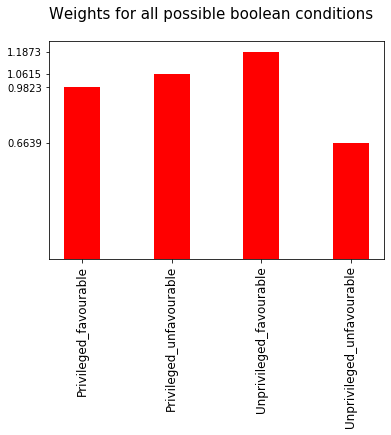

In [30]:
top=[('Privileged_favourable',w_p_fav),('Privileged_unfavourable',w_p_unfav),('Unprivileged_favourable',w_up_fav), ('Unprivileged_unfavourable',w_up_unfav)]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = .4

plt.suptitle('Weights for all possible boolean conditions', fontsize=15, y=1)

plt.bar(xs, ys, width, color='red')

plt.xticks(xs, labels, rotation=90, fontsize=12) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys, fontsize=10)


plt.show()


**Bias before and after reweighing**

In [31]:
DiscriminationBefore=(w_n_p_fav/n_p)-(w_n_up_fav/n_up)
DiscriminationAfter=(w_n_p_fav/n_p *w_p_fav)-(w_n_up_fav/n_up *w_up_fav )


DiscriminationBefore, DiscriminationAfter

(0.1340207177400593, 1.1102230246251565e-16)

**Adding a new column 'NewWeights' with weights calculated above**

In [32]:
datatest=data
datatest['NewWeights']= np.repeat(999, len(datatest)) 
datatest.loc[(datatest[choice]==pval) & (datatest['Default']==0), 'NewWeights'] = w_p_fav
datatest.loc[(datatest[choice]==pval) & (datatest['Default']==1), 'NewWeights'] = w_p_unfav
datatest.loc[(datatest[choice]==upval) & (datatest['Default']==0), 'NewWeights'] = w_up_fav
datatest.loc[(datatest[choice]==upval) & (datatest['Default']==1), 'NewWeights'] = w_up_unfav

**Frequency of each weight**

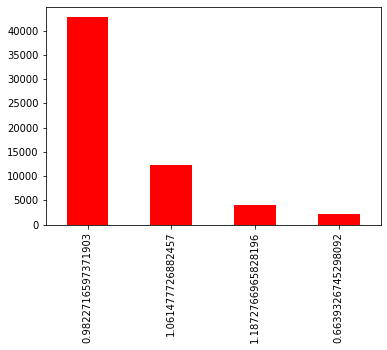

In [33]:
fig, ax = plt.subplots()
datatest['NewWeights'].value_counts().plot(ax=ax, kind='bar', color='red')
plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
The representation of unprivileged customers with unfavourable outcome is least and its weight as per reweighing algorithm is 0.663. Note the highest weight is for the instances with combination of favourable and unprivileged
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="5a"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Model development with and without weights</span>
</div>

**Missing value impuation for modelling**

In [34]:
datatest['MonthlyPayment'].fillna((datatest['MonthlyPayment'].mean()), inplace=True)
datatest['ExpectedLoss'].fillna((datatest['ExpectedLoss'].mean()), inplace=True)
datatest['ProbabilityOfDefault'].fillna((datatest['ProbabilityOfDefault'].mean()), inplace=True)
datatest['DebtToIncome'].fillna((datatest['DebtToIncome'].mean()), inplace=True)
datatest['FreeCash'].fillna((datatest['FreeCash'].mean()), inplace=True)
datatest['LossGivenDefault'].fillna(0, inplace=True)

#### Some classification definitions 
<img style="float: left; width: 500px; padding-right: 15px;" src="confusionMatrxiUpdated.jpg">  

<div class="alert alert-block alert-info">
<b>Remember:</b> 

<i>If we have a generic learning algorithm, increasing the sample weight should increase the effect of 
training on the sample.   
e.g. if we have a batched loss, instead of a sum over the batch we would do a weighted sum so higher weighted 
samples dominate the loss.  
In most cases, it is as simple as weighing the loss function, such that more important (or perhaps rarer) observations contribute more strongly to the loss and vice-versa</i>
</div>

In [35]:
target=['Default']

In [36]:
x=datatest.drop(columns=['Age', 'instance_weights','Default'])
y=datatest['Default']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=6666)

In [38]:
X_train_weights=X_train['NewWeights']
X_test_weights=X_test['NewWeights']

X_train1=X_train.drop(columns=["NewWeights"])
X_test1=X_test.drop(columns=["NewWeights"])


**Model without weights**

In [39]:
clf_wow = LogisticRegression(random_state=0, solver='lbfgs',
                              multi_class='ovr').fit(X_train1, y_train)


In [40]:
y_pred_wow=clf_wow.predict(X_test1)
y_pred_prob_wow=clf_wow.predict_proba(X_test1)[:,0]

**Total accuracy of the model**

In [41]:
print("Accuracy of the model without weights:", clf_wow.score(X_test1, y_test))

Accuracy of the model without weights: 0.7583301625264989


**Accuracy difference between privileged and unprivileged group**

In [42]:
A_wow=clf_wow.score(X_test1[X_test1[choice]==0], y_test[X_test1[choice]==0]) #pval = 0 is Priviliged
B_wow=clf_wow.score(X_test1[X_test1[choice]==1], y_test[X_test1[choice]==1]) #pval = 1 is Unpriviliged
print("Accuracy difference between two groups:", abs(B_wow-A_wow)*100, "%")

Accuracy difference between two groups: 13.862120361055453 %


**Model with weights**

<div class="alert alert-block alert-info">
<b>Remember:</b> Pass your sample weights obtained from reweighing as sample weights to training model.     

<i>If we have a generic learning algorithm, increasing the sample weight should increase the effect of 
training on the sample.   
e.g. if we have a batched loss, instead of a sum over the batch we would do a weighted sum so higher weighted 
samples dominate the loss.  
In most cases, it is as simple as weighing the loss function, such that more important (or perhaps rarer) observations contribute more strongly to the loss and vice-versa</i>
</div>

In [43]:
clf_ww = LogisticRegression(random_state=0, solver='lbfgs',
                              multi_class='ovr').fit(X_train1, y_train, sample_weight=X_train_weights)


In [44]:
y_pred_ww = clf_ww.predict(X_test1)
y_pred_prob_ww = clf_ww.predict_proba(X_test1)[:,0]

**Total accuracy of the model with weights**

In [45]:
print("Accuracy of the model with weights:", clf_ww.score(X_test1, y_test))

Accuracy of the model with weights: 0.7592542262325379


**Accuracy difference between privileged and unprivileged group (model with weights)**

In [46]:
A_ww=clf_ww.score(X_test1[X_test1[choice]==0], y_test[X_test1[choice]==0])
B_ww=clf_ww.score(X_test1[X_test1[choice]==1], y_test[X_test1[choice]==1])
print("Accuracy difference between two groups:", abs(B_ww-A_ww)*100, "%" )

Accuracy difference between two groups: 13.377956802780954 %


**Summary of model performace**

Metrics  | Without Weights | With Weights | Delta |
------------- | ------------- | ------------ |-------|
Overall Accuracy  | 0.7583 |0.7592| 0.0009|
Accuracy Difference  | 13.8621|13.3779|0.4841|

<div class="alert alert-block alert-success">
<b>Inference:</b>
The overall accuracy of models with weights (weights generated by reweighing algorithm) has improved by few points while the overall accuracy difference between privileged group and unprivileged group has become narrower. A win-win situation
</div>

### Various other accuracy metrics before and after reweighing

In [47]:
model_perf=[model_metrics(y_test, y_pred_prob_ww, y_pred_prob_wow, 
                          y_pred_ww, y_pred_wow, X_test1)]

headers=["AUC", "Gini", "Avg Precision Score", "Precision", "Sensitivity", "False Negative Rate", 
         "F1 Score", "Total Cost"]


#full_metric={'With Weights':B, 
#             'Without_Weights':list(ww[0]), 'Without_Weights':list(wow[0])}

#compare_table=pd.DataFrame.from_dict(ww_wow)

B = list(model_perf[0])[:len(list(model_perf[0]))//2]
C = list(model_perf[0])[len(list(model_perf[0]))//2:]


model_table={'Metrics':headers, 
             'With_Weights':B, 'Without_Weights':C}

model_table_df=pd.DataFrame.from_dict(model_table)
model_table_df.loc[8] = ['Total Cost (in Mn)', model_table_df.iloc[7,1]/10000000, model_table_df.iloc[7,2]/10000000]
#model_table_df

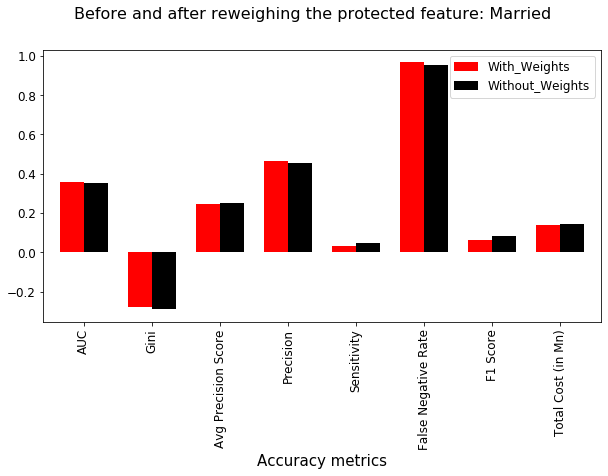

In [48]:
#plt.clf()
#plt.figure()

labeltext='Married'


ax = model_table_df.iloc[[0,1,2,3,4,5,6,8],:].plot.bar(x='Metrics', rot=90, width = 0.7, 
                                                       color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Before and after reweighing the protected feature: {}'.format(labeltext),  fontsize=16, y=1)



patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Accuracy metrics', fontsize=15)


#plt.savefig('BnAR.svg', format='svg', dpi=500, bbox_inches='tight') #,
#plt.savefig('BnAR.png', format='png', dpi=500, bbox_inches='tight')
#beingsaved = plt.figure()
#beingsaved.savefig('BnAR.eps', format='eps', dpi=500)

plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
After using weights (generated from reweighing algorithm) metrics like AUC, precision, false negative rate has increased while gini, sensitivity, F1 score and cost has decreased significantly.
    
<b> PS: Cost here is 700 for each FP and 300 for each FN</b>
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="5b"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Fairness metrics post model training</span>
</div>

[Fairness definitions explained](http://fairware.cs.umass.edu/papers/Verma.pdf)

**Average Odds ratio**: average of difference in FPR and TPR for unprivileged and privileged groups

$$
\begin{array}
½ [(FPR_{S=unprivileged}−FPR_{S=privileged}) + (TPR_{S=privileged}−TPR_{S=unprivileged}))]
\end{array}
$$

**Equal Opportunity** (for false negative rate): both protected and unprotected groups have equal FNR
    
$$
\begin{array}
\mathbb{P}( \hat{Y} = 0 \mid {Y} = 1,\mathbf{S} = \mathbf{T}_{a}) =\mathbb{P} ( \hat{Y} = 0 \mid {Y} = 1, \mathbf{S} = \mathbf{T}_{d} )
\end{array}
$$

**Predictive Equality** (for false positive rate): both protected and unprotected groups have equal FPR
$$
\begin{array}
\mathbb{P} ( Y= 1   \mid \hat{Y} = 0,\mathbf{S} = \mathbf{T}_{a}) = \mathbb{P} (Y = 1 \mid \hat{Y} = 0, \mathbf{S} = \mathbf{T}_{d} )
\end{array}
$$

**Equalised Odds**: equal TPR and FPR
$$
\begin{array}
\mathbb{P}( \hat{Y} = 1 \mid {Y} = i,\mathbf{S} = \mathbf{T}_{a}) = \mathbb{P} (\hat{Y} = 1 \mid {Y} = i, \mathbf{S} = \mathbf{T}_{d} ), i ∈ 0, 1
\end{array}
$$

**Treatment Equality**: equal ratio of false negatives and false positives
$$
\begin{array}
(FN / FP)_{\mathbf{S} = \mathbf{T}_{a}} = (FN / FP)_{\mathbf{S}=\mathbf{T}_{d}}
\end{array}
$$

**Predictive Parity**: both protected and unprotected groups have equal PPV
$$
\begin{array}
\mathbb{P} ( Y= 1 \mid \hat{Y} = 1,\mathbf{S} = \mathbf{T}_{a}) = \mathbb{P} (Y = 1  \mid \hat{Y} = 1, \mathbf{S} = \mathbf{T}_{d} )
\end{array}
$$

**Demographic Parity**: membership in a protected class should have no correlation with the decision
$$
\begin{array}
\mathbb{P} ( \hat{Y} = 1 \mid  \mathbf{S} = \mathbf{T}_{a}) = \mathbb{P} (\hat{Y} = 1 \mid \mathbf{S} = \mathbf{T}_{d} )
\end{array}
$$

In [49]:
ww=[perf_metrics(y_test, y_pred_prob_ww, y_pred_ww, X_test1, choice, pval, upval)]
wow=[perf_metrics(y_test, y_pred_prob_wow, y_pred_wow, X_test1, choice, pval, upval)]
headers=["Area Under Curve", "Avg Precision Score", "Eq of Opportunity", "Eq Of Odds", "Precision", 
         "Demographic Parity", "Avg Odds Diff", "Predictive Equality", "Treatment Equality", "Predictive Parity",
         "Cost Diff", "Total Cost"]

In [50]:
ww_wow={'Metrics':headers, 
             'With_Weights':list(ww[0]), 'Without_Weights':list(wow[0])}

compare_table=pd.DataFrame.from_dict(ww_wow)
compare_table.loc[12] = ['Total Cost (in Mn)', compare_table.iloc[11,1]/10000000, compare_table.iloc[11,2]/10000000]

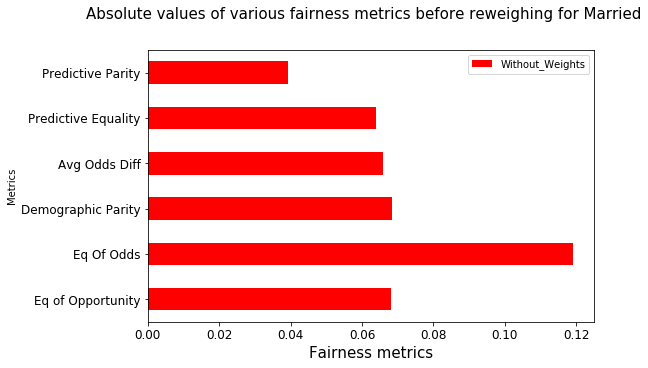

In [51]:
ax = compare_table.iloc[[2,3,5,6,7,9],[0,2]].plot.barh(x='Metrics', width = 0.5, color=['red', 'black'], 
                                                       figsize=(8,5), fontsize=12)
plt.suptitle('Absolute values of various fairness metrics before reweighing for {}'.format(labeltext),  
             fontsize=15, y=1)

#patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='upper right', fontsize=12)


ax.set_xlabel('Fairness metrics', fontsize=15)

plt.show()

#### Difference in metrics (accuracy and fairness) between two groups before and after

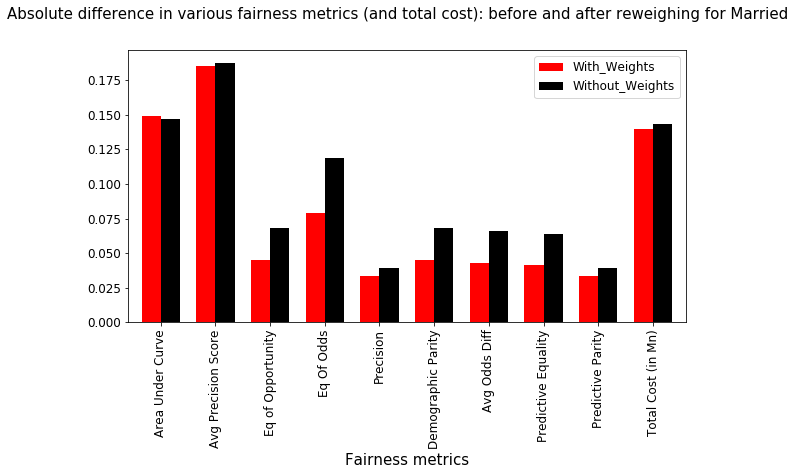

In [52]:
ax = compare_table.iloc[[0,1,2,3,4,5,6,7,9,12],:].plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], 
                                                           figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference in various fairness metrics (and total cost): before and after reweighing for {}'.format(labeltext),  
             fontsize=15, y=1)

#'f model: T= {}'.format(t)


patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)


ax.set_xlabel('Fairness metrics', fontsize=15)


#plt.savefig('ADF.svg', format='svg', dpi=500, bbox_inches='tight')
#plt.savefig('ADF.png', format='png', dpi=500, bbox_inches='tight')

#beingsaved = plt.figure()
#beingsaved.savefig('ADF.eps', format='eps', dpi=500)


plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
It can be seen that by using weights (as generated by reweighing technique) almost all fairness metrics are performing better than in the case of model without weights.    
Equality of opportunity, predictive parity and predictive equality has the best result as it has improved drastically. In terms of delta, equality of odds has shown maximum improvement
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="6"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Accuracy-cost-fairness trade-off</span>
</div>

<a id="6a"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Calibrating across single threshold</span>
</div>

In [53]:
thresholds = np.arange(0, 1.01, 0.01)

In [54]:
#Higher probablity is 0 in binary
#Lower probablity is 1 in binary

In [55]:
EOpp, EOdds, demo_parity, AOD, p_eq, TE, pp, TNR, precision, FPR, f1, roc, sensitivity, fnr, fp, fn, cost = on_same_threshold(X_test1, y_test, choice, y_pred_prob_wow, pval, upval)

In [56]:
#EOpp, EOdds, demo_parity, AOD, p_eq, TE, pp, TNR, precision, FPR, f1, roc, sensitivity, fnr, fp, fn, cost = on_same_threshold(X_test1, y_test, choice, y_pred_prob_ww, pval, upval)

In [57]:
cost = [x / 100000 for x in cost]

same_thresholds={'Threshold':thresholds, 
             'Eq of Opportunity':EOpp, 'Eq of Odds':EOdds, 'Demographic Parity': demo_parity,
                 'Avg Odds':AOD, 'Pred equality':p_eq, 'Treatment eq':TE, 'Pred Parity':pp,
                 'True Negative Rate': TNR, 'Precision': precision, 'False Positive Rate':FPR, 
                 "F1": f1, "Area Under Curve":roc , "Sensitivity":sensitivity, "False Negative Rate":fnr,
                 "FP":fp, "FN":fn,
                 'Cost':cost}

same_thresholds_table=pd.DataFrame.from_dict(same_thresholds)
same_thresholds_table = same_thresholds_table.fillna(0)
#same_thresholds_table.tail(10)

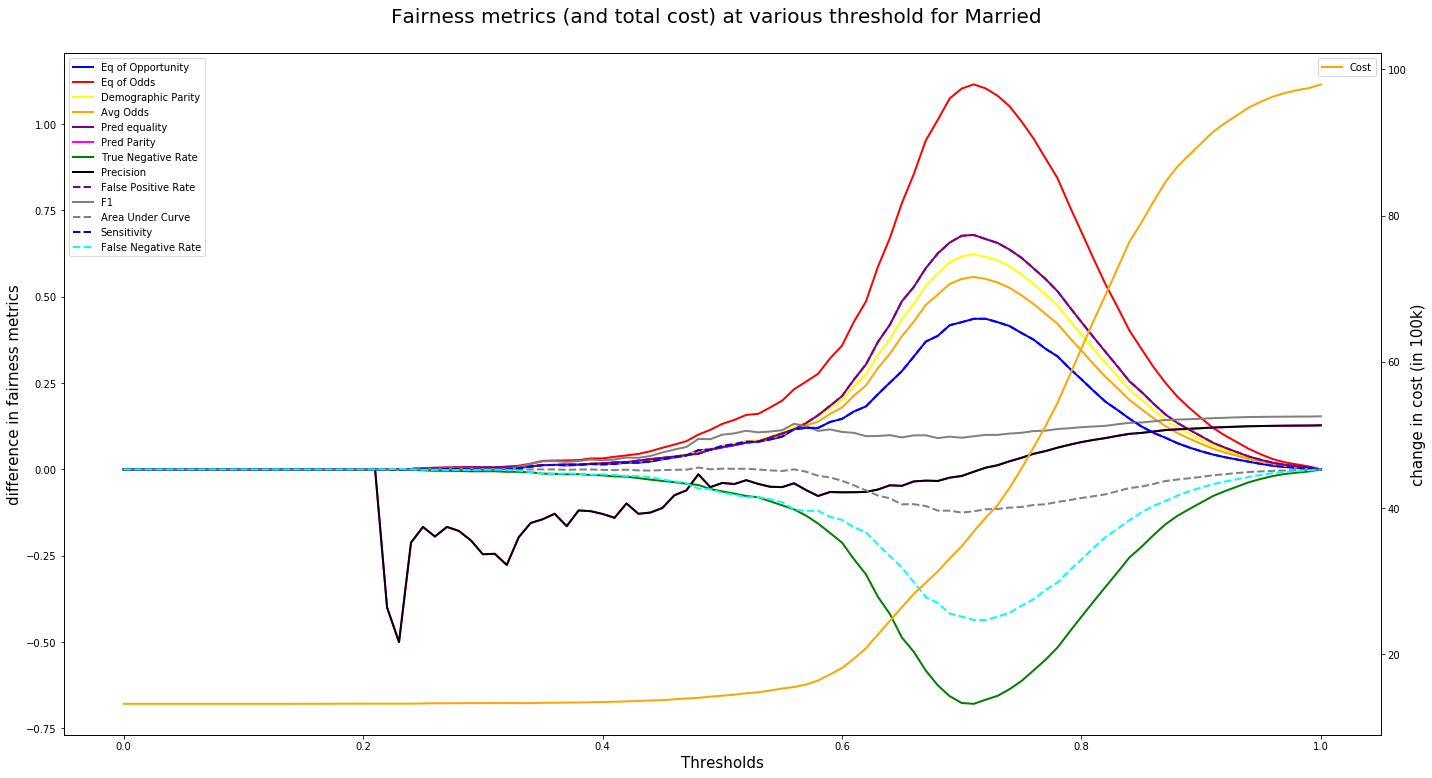

In [58]:
#plt.figure()

fig, ax1 = plt.subplots(figsize=(20,10))

fig.suptitle('Fairness metrics (and total cost) at various threshold for {}'.format(labeltext), fontsize=20, y=1.05)


ax1.plot( 'Threshold', 'Eq of Opportunity', data=same_thresholds_table, marker='', color='blue', linewidth=2)
ax1.plot( 'Threshold', 'Eq of Odds', data=same_thresholds_table, marker='', color='red', linewidth=2)
ax1.plot( 'Threshold', 'Demographic Parity', data=same_thresholds_table, marker='', color='yellow', linewidth=2)




ax1.plot( 'Threshold', 'Avg Odds', data=same_thresholds_table, marker='', color='orange', linewidth=2)
ax1.plot( 'Threshold', 'Pred equality', data=same_thresholds_table, marker='', color='purple', linewidth=2)
#ax1.plot( 'Threshold', 'Treatment eq', data=same_thresholds_table, marker='', color='yellow', linewidth=2)
ax1.plot( 'Threshold', 'Pred Parity', data=same_thresholds_table, marker='', color='magenta', linewidth=2)



ax1.plot( 'Threshold', 'True Negative Rate', data=same_thresholds_table, marker='', color='green', linewidth=2)
ax1.plot( 'Threshold', 'Precision', data=same_thresholds_table, marker='', color='black', linewidth=2)
ax1.plot( 'Threshold', 'False Positive Rate', data=same_thresholds_table, marker='', linestyle='--', color='purple', linewidth=2)
ax1.plot( 'Threshold', 'F1', data=same_thresholds_table, marker='', color='grey', linewidth=2)
ax1.plot( 'Threshold', 'Area Under Curve', data=same_thresholds_table, marker='', linestyle='--', color='grey', linewidth=2)
ax1.plot( 'Threshold', 'Sensitivity', data=same_thresholds_table, marker='', linestyle='--', color='blue', linewidth=2)
ax1.plot( 'Threshold', 'False Negative Rate', data=same_thresholds_table, marker='', linestyle='--', color='cyan', linewidth=2)



#ax1.plot( 'Threshold', 'FP', data=same_thresholds_table, marker='', color='black', linewidth=2)
#ax1.plot( 'Threshold', 'FN', data=same_thresholds_table, marker='', color='black', linewidth=2)





ax2 = ax1.twinx() 
ax2.plot( 'Threshold', 'Cost', data=same_thresholds_table, marker='', color='orange', linewidth=2)



patches, labels = ax1.get_legend_handles_labels()
ax1.legend(patches, labels, loc='upper left', fontsize=10)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, loc='upper left', fontsize=14)


ax1.set_ylabel('difference in fairness metrics', fontsize=15)
ax2.set_ylabel('change in cost (in 100k)', fontsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()

ax1.set_xlabel('Thresholds', fontsize=15)



#plt.savefig('FatVT.svg', format='svg', dpi=500, bbox_inches='tight')
#plt.savefig('FatVT.png', format='png', dpi=500, bbox_inches='tight')

#beingsaved = plt.figure()
#beingsaved.savefig('FatVT.eps', format='eps', dpi=500)

plt.show()
#plt.clf()

<div class="alert alert-block alert-success">
<b>Inference:</b>
The cost is minimum at lower threshold and increase significantly after 0.80.         
The fairness metrics has acceptable values every where except for thresholds between 0.60-0.80.         
The accuracy difference between two classes in minimum everywhere except for thresholds between 0.60-0.80.
Thus, there seems a very distinct trade-off between fairness-cost-accuracy.    
In order to minimize cost, maximize accuracy and maintain fairness, the best range of threshold would be between 0.40-0.60 
</div>

<span style="float:right;"> [TOC](#TOC) </span>

---

<a id="6b"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Calibrating across different threshold for two groups</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>
    In this case both the group would have different threshold, thus very likely this is a disrimination in itself
</div>

In [59]:
t_p, t_up, metric, Cost = on_diff_threshold(X_test1, y_test, choice, y_pred_prob_wow, pval, upval)

In [60]:
#t_p, t_up, metric, Cost = on_diff_threshold(X_test1, y_test, choice, y_pred_prob_ww, pval, upval)

In [61]:
diff_thresholds={'Metrics':metric, 
             'Threshold Privileged':t_p, 'Threshold Unprivileged':t_up, 'Cost': Cost}

diff_thresholds_table=pd.DataFrame.from_dict(diff_thresholds)

In [62]:

data = diff_thresholds_table

fig = px.scatter(data, x="Threshold Privileged", y="Threshold Unprivileged",
                 size="Cost", color="Metrics", hover_name="Metrics") #, log_x=True, size_max=60



fig.update_layout(
    title='Fairness metrics (and total cost as bubble size) at various thresholds for {}'.format(labeltext),
    xaxis=dict(
        title='Threshold Privileged',
        gridcolor='white',
        gridwidth=2,
    ),
    yaxis=dict(
        title='Threshold Unprivileged',
        gridcolor='white',
        gridwidth=2,
    )
)

fig.update_layout(margin=dict(l=50, r=50, t=50, b=10, pad=4),legend_orientation="h") #



#fig.write_image("fig1.png", scale=25)


fig.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
    The cost seems to be low for both groups at lower thresholds (less than 0.60 for privileged group and 0.50 for unprivileged group). The fairness metrics are also accptable in the same range. If the objective is to have maintain all fairness metrics (except positive predictive value) then threshold between 0.45 to 0.50 for privileged and 0.30-0.35 for unprivileged seems apt. 
</div>

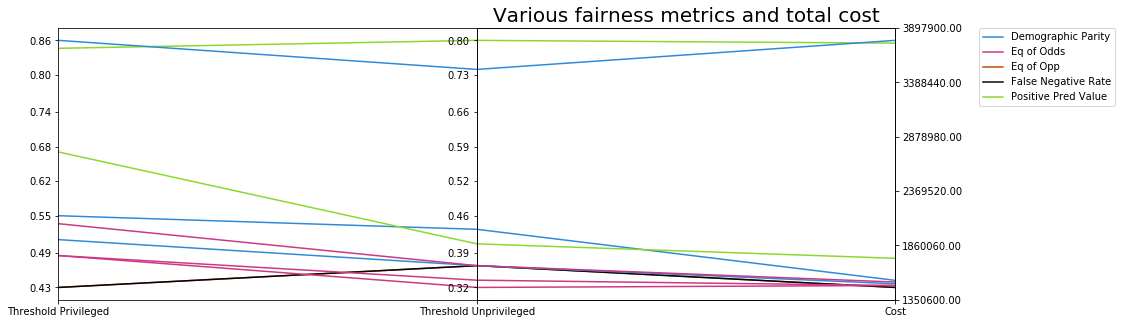

In [63]:
df=diff_thresholds_table.copy()
df['Metrics']=df['Metrics'].astype('category')

from matplotlib import ticker


cols = ['Threshold Privileged', 'Threshold Unprivileged', 'Cost']
x = [i for i, _ in enumerate(cols)]
colours = ['#2e8ad8', '#cd3785', '#c64c00', '#01060b', '#8ad82e', '#d87c2e']

#8ad82e



# create dict of categories: colours
colours = {df['Metrics'].cat.categories[i]: colours[i] 
           for i, _ in enumerate(df['Metrics'].cat.categories)}




# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

# Get min, max and range for each column
# Normalize the data for each column


min_max_range = {}
for col in cols:
    min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
    df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))
     
    
    
# Plot each row
for i, ax in enumerate(axes):
    for idx in df.index:
        mpg_category = df.loc[idx, 'Metrics']
        ax.plot(x, df.loc[idx, cols], colours[mpg_category])
    ax.set_xlim([x[i], x[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    
    mn = min_max_range[cols[dim]][0]

    labels = list()
    ticks = len(ax.get_yticklabels())
    #print (ticks)
    for i in range(ticks):
        v = mn + i*step
        labels.append('%4.2f' % v)
    ax.set_yticklabels(labels)
    #print (labels)
    
    
    
    norm_min = df[cols[dim]].min()
    norm_range = np.ptp(df[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    #ax.set_yticklabels(labels)
    #print(ticks, labels)
    


for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]])


# Remove space between subplots
plt.subplots_adjust(wspace=0)
plt.title("Various fairness metrics and total cost", fontsize=20)


# Add legend to plot
plt.legend(
    [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df['Metrics'].cat.categories],
    df['Metrics'].cat.categories,
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


#plt.savefig('PPC.svg', format='svg', dpi=500, bbox_inches='tight')
#plt.savefig('PPC.png', format='png', dpi=500, bbox_inches='tight')
#beingsaved = plt.figure()
#beingsaved.savefig('PPC.eps', format='eps', dpi=500)


plt.show()
    




<div class="alert alert-block alert-success">
<b>Inference:</b>
    The same thing is quite visible here too. For all fairness metrics (except positive predictive value), threshold between 0.40 to 0.50 for privileged and 0.30 to 0.40 for unprivileged seems apt
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="8"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Additive counterfactual fair model</span>
</div>

The implementation of a [**linear counterfactually fair**](https://arxiv.org/pdf/1703.06856.pdf) model uses the each of the protected class variable ($\mathbf{S}$) to compute the residuals for each input variable ($\mathbf{X}$) and then calculate the residuals as a difference between actual and predicted values ($\mathbf{X}-\hat{X}$) which is then used to learn a function that maps from inputs to the target variable ($\mathbf{Y}$). 

ACF,within the framework of counterfactual fairness, is the idea that we model the correlations between  ${S}$  and features in  ${X}$  by training linear models to predict each feature  ${X_j}$  using  ${S}$  as input.

Then, we can compute the residuals  ${ϵ_{ij}}$  between predicted and true feature values for each observation  ${i}$  and feature  ${j}$ . The final model is then trained on  ${ϵ_{ij}}$  as features to predict  ${y}$


$$
\begin{array}{c}{X_{1}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{1}} \\ {X_{n}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{n}} \\ {\epsilon_{X1}={X_{1}}-\hat{X_{1}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {\epsilon_{Xn}={X_{n}}-\hat{X_{n}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {Y=\beta_{0}+\beta_{1} \epsilon_{X1}+\cdots+\beta_{n} \epsilon_{Xn}}\end{array}
$$


<a id="8a"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Classification (multiple protected features)</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>
    
- Here the target variable is:
 - Default
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - NrOfDependantslessthan3
 - MaritalStatus_1.0
 - MaritalStatus_3.0
 - MaritalStatus_4.0
</div>

In [64]:
choice = 'MaritalStatus_3.0' #Single

In [65]:
dataacf = datatest[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment',
"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

## Full model : Logistic Regression


In [66]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [67]:
clf_full = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(X_train, y_train)


In [68]:
y_pred=clf_full.predict(X_test)
y_pred_prob=clf_full.predict_proba(X_test)[:,0]
print("Accuracy of the full model:", clf_full.score(X_test, y_test))

Accuracy of the full model: 0.7739910313901345


In [69]:
A_full=clf_full.score(X_test[X_test[choice]==0], y_test[X_test[choice]==0]) #pval = 0 is Priviliged
B_full=clf_full.score(X_test[X_test[choice]==1], y_test[X_test[choice]==1]) #pval = 1 is Unpriviliged
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 16.600874346801465 %


In [70]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]).ravel()
#y_true, y_pred

In [71]:
Fullmodel = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

## Additive counterfactual fair model

In [72]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

**Selecting few protected / sensitive features**

In [73]:
sens=X_train[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

**Regressing each independent variable with sensitive variable**

In [74]:
clf_age = LinearRegression().fit(sens, X_train['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_train['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

**Residual of each model**

In [75]:
ageR = X_train['Age'] - clf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [76]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Fitting residuals to the dependent (target) variable**

In [77]:
fair = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(df_R, y_train)

**Regressing each independent variable with sensitive variable on test data**

In [78]:
sens=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

In [79]:
clf_age = LinearRegression().fit(sens, X_test['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_test['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_test['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_test['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_test['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_test['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_test['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_test['MonthlyPayment'])

**Residual of each model on test data**

In [80]:
ageR = X_test['Age'] - clf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [81]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Predicting the target variable on fair model developed above**

In [82]:
pred_fair_te = fair.predict(df_R_test)

In [83]:
print("Accuracy of the ACF model:",fair.score(df_R_test, y_test))

Accuracy of the ACF model: 0.7668161434977578


In [84]:
A_fair=fair.score(df_R_test[sens[choice]==0], y_test[sens[choice]==0]) #pval = 0 is Priviliged
B_fair=fair.score(df_R_test[sens[choice]==1], y_test[sens[choice]==1]) #pval = 1 is Unpriviliged
print("Accuracy difference of the ACF model between two groups:", abs(B_fair-A_fair)*100, "%")

Accuracy difference of the ACF model between two groups: 19.649270808429243 %


In [85]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]).ravel()
#y_true, y_pred

In [86]:
ACFmodel = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

**Comparing full model with ACF fair model**

In [87]:
headers=["Eq of Opportunity", "Eq Of Odds", "Precision", 
         "Demographic Parity", "Avg Odds Diff", "Predictive equality", "Predictive Parity", "True Positive Rate", 
         'cost (in Mn)']
ACF={'Metrics':headers, 
             'Full Model':list(Fullmodel), 'ACF Fair Model':list(ACFmodel)}
ACF_table=pd.DataFrame.from_dict(ACF)

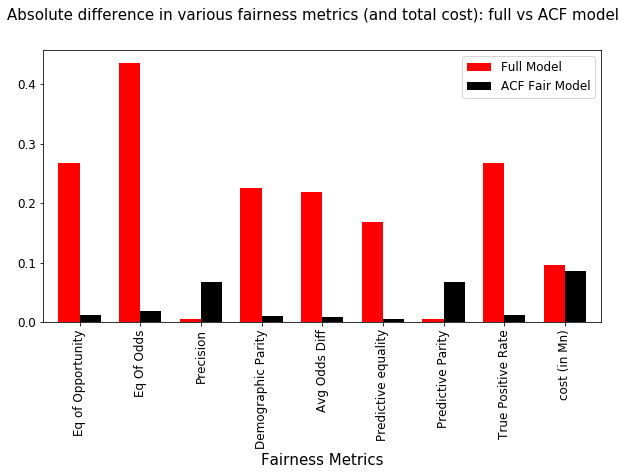

In [88]:
ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference in various fairness metrics (and total cost): full vs ACF model',  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
    All fairness metrics shows improvement and thus proving that the model is much bias-free in case of ACF fair model. The cost seems to have gone down in ACF fair model compared to full model. However, metrics like precision and predictive parity is showing some trade-off.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="8b"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Regression (multiple protected features)</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>

- Here the target variable:
 - ProbabilityOfDefault
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - NrOfDependantslessthan3
 - MaritalStatus_1.0
 - MaritalStatus_3.0
 - MaritalStatus_4.0
 </div>

In [89]:
choice = 'MaritalStatus_3.0' #Single

In [90]:
dataacf_Lin = datatest[['ProbabilityOfDefault','Age', 'AppliedAmount', 'ExpectedLoss', 
                        'LiabilitiesTotal', 'IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment',
"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

## Full model : Linear Regression
Here we are slecting probablity of default as the target feature and would predict this value using linear regression algorithm

In [91]:
y=dataacf_Lin['ProbabilityOfDefault']*1000
x=dataacf_Lin.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969) #6699

In [92]:
clf_full_Lin = LinearRegression().fit(X_train, y_train)
y_pred=clf_full_Lin.predict(X_test)
print("For full model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", RMSE(y_pred, y_test))
print("Mean Absolute Percentage Error:", mape(y_pred, y_test))


For full model:
Mean Squared Error: 1991.3528630946953
Root Mean Squared Error: 44.62457689541376
Mean Absolute Percentage Error: 22.862083236717524


In [93]:
print("For full model:")
A_full=mean_squared_error(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=mean_squared_error(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Mean Squared Error difference:", abs(B_full-A_full))

A_full=RMSE(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=RMSE(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Root Mean Squared Error: difference", abs(B_full-A_full))


A_full=mape(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=mape(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Mean Absolute Percentage Error: difference", abs(B_full-A_full))

For full model:
Mean Squared Error difference: 517.3058864416853
Root Mean Squared Error: difference 6.13462675166425
Mean Absolute Percentage Error: difference 1.061936075034673


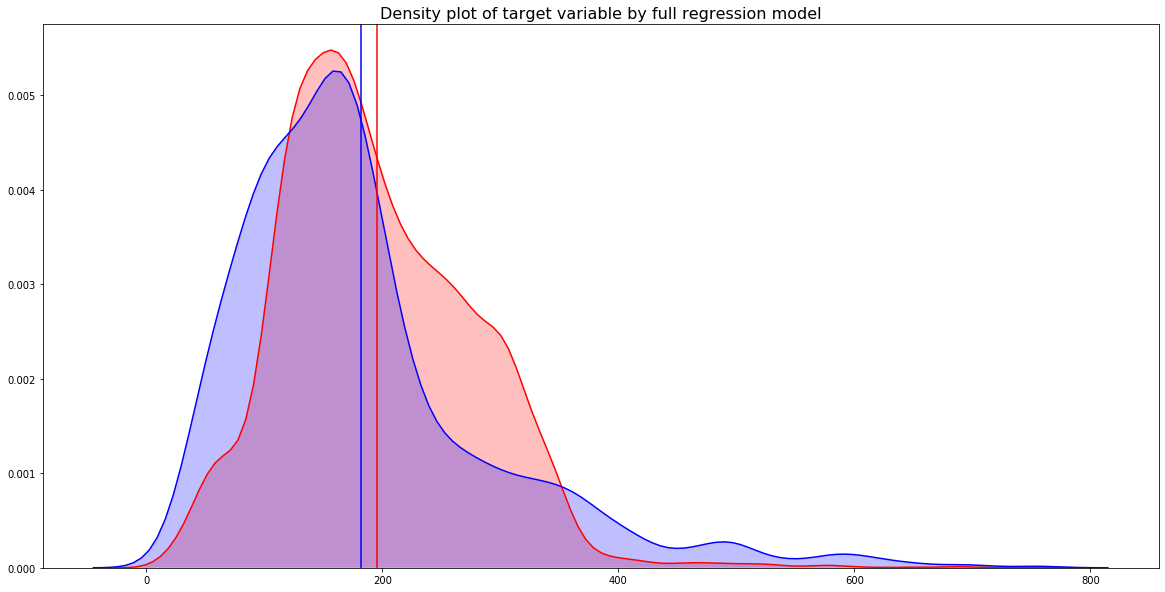

Mean difference of predicted target value (Full Model) between two groups: 13.52945625521528
Skewness difference of predicted target value (Full Model) between two groups: -0.9013968560270103
Kurtosis difference of predicted target value (Full Model) between two groups: -1.9288666897579843


In [94]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_pred[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_pred[X_test[choice]==1], shade=True, color="b")
#print(np.mean(y_pred[X_test[choice]==0]) - np.mean(y_pred[X_test[choice]==1]))

plt.title('Density plot of target variable by full regression model', fontsize=16)
plt.axvline(np.mean(y_pred[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_pred[X_test[choice]==1]), color="b")

#plt.legend()
plt.show()

print("Mean difference of predicted target value (Full Model) between two groups:", np.mean(y_pred[X_test[choice]==0]) - 
      np.mean(y_pred[X_test[choice]==1]))
print("Skewness difference of predicted target value (Full Model) between two groups:", skew(y_pred[X_test[choice]==0]) - 
      skew(y_pred[X_test[choice]==1]))
print("Kurtosis difference of predicted target value (Full Model) between two groups:", kurtosis(y_pred[X_test[choice]==0]) - 
      kurtosis(y_pred[X_test[choice]==1]))

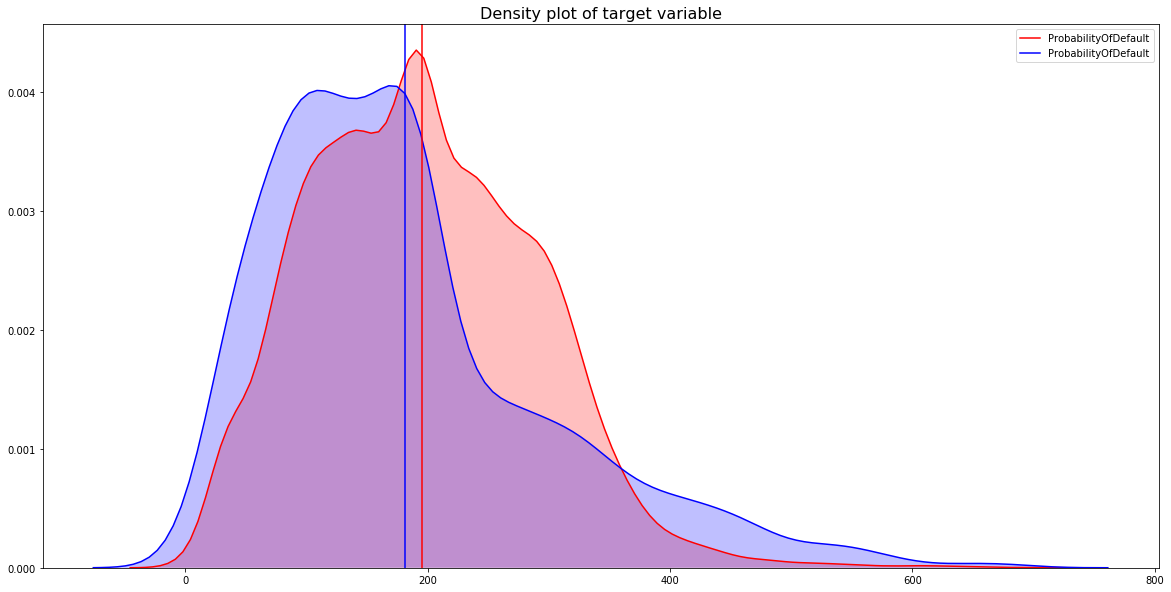

Mean difference of target value between two groups: 14.366330625236145
Skewness difference of target value between two groups: -0.7214417587308593
Kurtosis difference of target value between two groups: -0.9918627356965497


In [95]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_test[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_test[X_test[choice]==1], shade=True, color="b")
#print(np.mean(y_test[X_test[choice]==0])-(np.mean(y_test[X_test[choice]==1])))

plt.title('Density plot of target variable', fontsize=16)
plt.axvline(np.mean(y_test[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_test[X_test[choice]==1]), color="b")

#plt.legend()
plt.show()

print("Mean difference of target value between two groups:", np.mean(y_test[X_test[choice]==0]) -
      (np.mean(y_test[X_test[choice]==1])))
print("Skewness difference of target value between two groups:", skew(y_test[X_test[choice]==0]) -
      (skew(y_test[X_test[choice]==1])))
print("Kurtosis difference of target value between two groups:", kurtosis(y_test[X_test[choice]==0]) -
      (kurtosis(y_test[X_test[choice]==1])))


## Additive counterfactual fair model

In [96]:
y=dataacf_Lin['ProbabilityOfDefault']*1000
x=dataacf_Lin.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969)

**Selecting few protected / sensitive features**

In [97]:
sens=X_train[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

**Regressing each independent variable with all sensitive variables**

In [98]:
clf_age = LinearRegression().fit(sens, X_train['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_train['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

**Residual of each models**

In [99]:
ageR = X_train['Age'] - clf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [100]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Fitting residuals to the dependent (target) variable**

In [101]:
fair = LinearRegression().fit(df_R, y_train)

**Regressing each independent variable with sensitive variables on test data**

In [102]:
sens=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

In [103]:
clf_age = LinearRegression().fit(sens, X_test['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_test['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_test['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_test['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_test['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_test['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_test['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_test['MonthlyPayment'])

**Residual of each model on test data**

In [104]:
ageR = X_test['Age'] - clf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [105]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Predicting the target variable on fair model developed above**

In [106]:
pred_fair_te = fair.predict(df_R_test)

In [107]:
print("For ACF model:")
print("Mean Squared Error:",mean_squared_error(y_test, pred_fair_te))
print("Root Mean Squared Error:", RMSE(pred_fair_te, y_test))
print("Mean Absolute Percentage Error:", mape(pred_fair_te, y_test))

For ACF model:
Mean Squared Error: 2442.6078661946876
Root Mean Squared Error: 49.422746445282534
Mean Absolute Percentage Error: 28.251163055694807


In [108]:
print("For ACF model:")
A_fair=mean_squared_error(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=mean_squared_error(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Mean Squared Error difference:", abs(B_fair-A_fair))


A_fair=RMSE(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=RMSE(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Root Mean Squared Error difference:", abs(B_fair-A_fair))


A_fair=mape(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=mape(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Mean Absolute Percentage Error difference:", abs(B_fair-A_fair))

For ACF model:
Mean Squared Error difference: 840.4945829206613
Root Mean Squared Error difference: 9.193268944063973
Mean Absolute Percentage Error difference: 3.6977921510466736


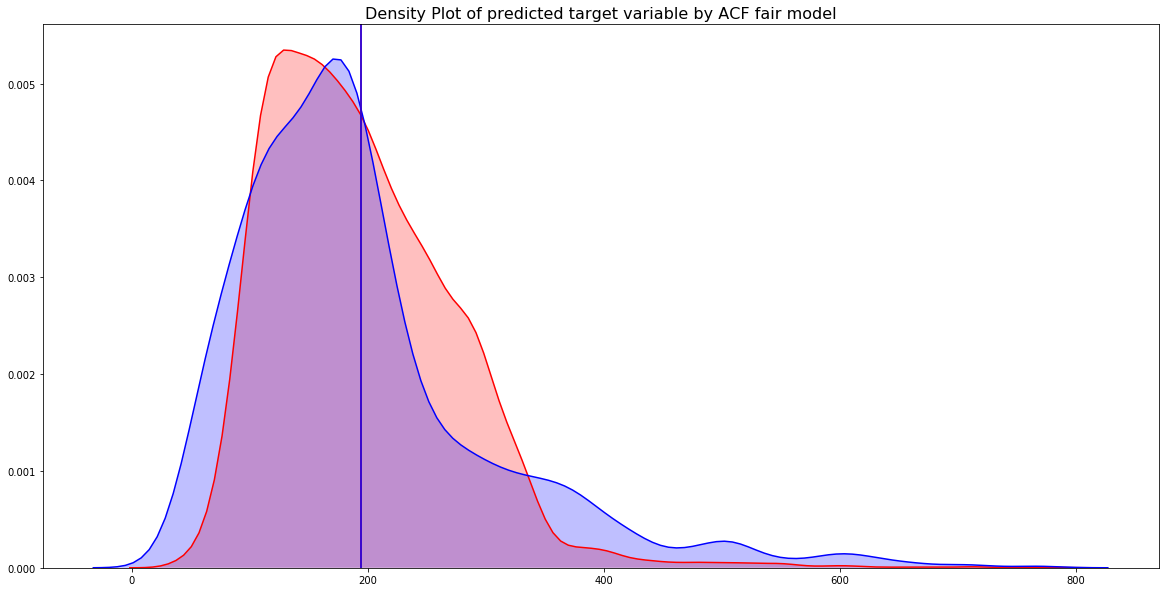

Mean difference of predicted target value (ACF Model) between two groups: 2.842170943040401e-14
Skewness difference of predicted target value (ACF Model) between two groups: -0.49521708845611867
Kurtosis difference of predicted target value (ACF Model) between two groups: -0.4439708520125363


In [109]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(pred_fair_te[sens[choice]==0], shade=True, color="r")
p1=sns.kdeplot(pred_fair_te[sens[choice]==1], shade=True, color="b")
plt.title('Density Plot of predicted target variable by ACF fair model', fontsize=16)
plt.axvline(np.mean(pred_fair_te[sens[choice]==0]), color="r" )
plt.axvline(np.mean(pred_fair_te[sens[choice]==1]), color="b")

#plt.legend()
plt.show()

print("Mean difference of predicted target value (ACF Model) between two groups:", np.mean(pred_fair_te[sens[choice]==0]) - 
      np.mean(pred_fair_te[sens[choice]==1]))
print("Skewness difference of predicted target value (ACF Model) between two groups:", skew(pred_fair_te[sens[choice]==0]) - 
      skew(pred_fair_te[sens[choice]==1]))
print("Kurtosis difference of predicted target value (ACF Model) between two groups:", kurtosis(pred_fair_te[sens[choice]==0]) - 
      kurtosis(pred_fair_te[sens[choice]==1]))

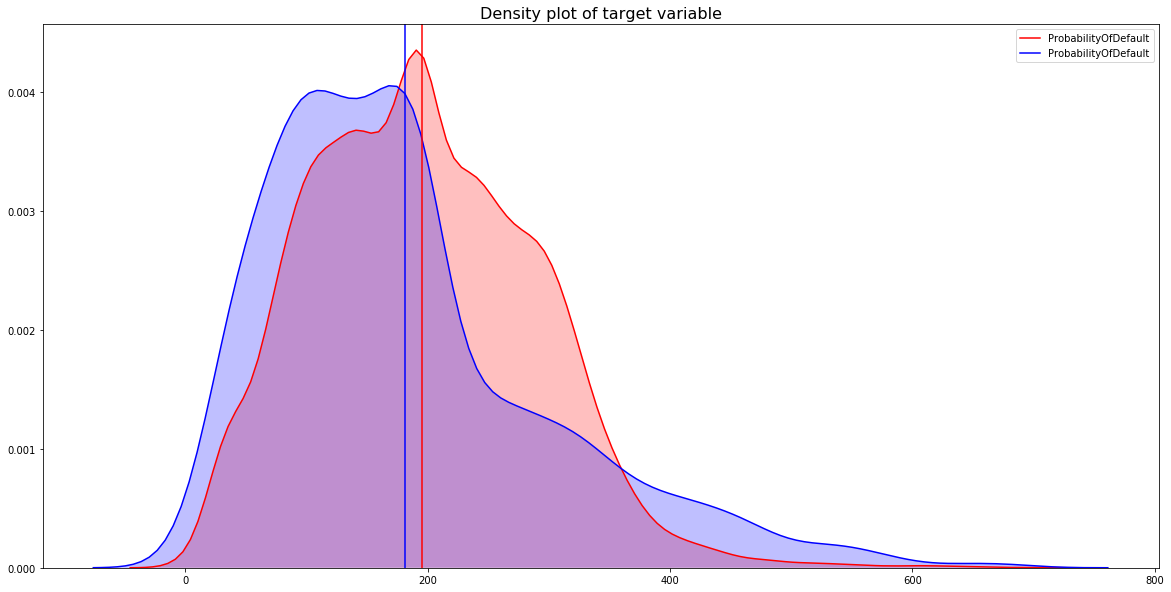

Mean difference of target value between two groups: 14.366330625236145
Skewness difference of target value between two groups: -0.7214417587308593
Kurtosis difference of target value between two groups: -0.9918627356965497


In [110]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_test[sens[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_test[sens[choice]==1], shade=True, color="b")
plt.title('Density plot of target variable', fontsize=16)
plt.axvline(np.mean(y_test[sens[choice]==0]), color="r")
plt.axvline(np.mean(y_test[sens[choice]==1]), color="b")

plt.show()

print("Mean difference of target value between two groups:", np.mean(y_test[sens[choice]==0]) - 
      np.mean(y_test[sens[choice]==1]))
print("Skewness difference of target value between two groups:", skew(y_test[sens[choice]==0]) - 
      skew(y_test[sens[choice]==1]))
print("Kurtosis difference of target value between two groups:", kurtosis(y_test[sens[choice]==0]) - 
      kurtosis(y_test[sens[choice]==1]))

**Summary of Model performace**

Metrics  | Data | Full Model | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | 14.3 |13.5| 2.8e-14
Skewness  | -0.72|-0.90|-0.49
Kurtosis  | -0.99|-1.92|-0.44

<div class="alert alert-block alert-success">
<b>Inference:</b>
    The distribution of target value (probablity of default) between two groups is quite varied in the original data (evident from the large difference in mean, skewness and kurtosis) and has worsed when a full model was developed using linear regression algorithm. However, the ACF model show that the distribution of target value among the two groups is very similar and the difference in mean, skeweness and kurtosis has reduced dramatically.
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>
The theme of CF is <b>"What would have been my prediction if - all else held causally equal - I was memeber of another protected group?"</b>
    
Theoretically to check the need of ACF model for some predictor ${Y}$ with data ${D}$={${x_i}$, ${s_i}$}, first develop a full model ${M}$ with all features and fit the test data with as is sensitive features ${S}$ and note the predictions $\hat{Y}$ and error $\epsilon$. In next steps fit the model again with the inverse of ${S}$ i.e., ${S'}$ and find the predictions $\hat{Y'}$ and $\epsilon'$. In third step find ${E}$ as $\hat{Y} - \hat{Y'}$ and  $\epsilon$-$\epsilon'$ to satisfy:

$$
\begin{array}
{P}(\hat{Y}_{{s}={s'}}={Y} \mid {X}={x}, {S}={s'}) = {P}(\hat{Y}_{{s}={s}}={Y} \mid {X}={x}, {S}={s})
\end{array}
$$
    
In next set of steps, for ${M}_{ACF}$ model, fit the test data with as is sensitive features ${S}$ and note the predictions $\hat{Y}_{ACF}$ and error $\epsilon_{ACF}$. In next steps fit the model again with inverse of ${S}$ i.e., ${S'}$ and find the predictions $\hat{Y'}_{ACF}$. In third step find ${E'}$ as $\epsilon'_{ACF}$ as $\hat{Y}_{ACF}- \hat{Y'}_{ACF}$ and  $\epsilon_{ACF}-\epsilon'_{ACF}$ to satisfy:
$$
\begin{array}
{P}(\hat{Y}_{{s}={s'}}={Y} \mid {X}={x}, {S}={s'}) = {P}(\hat{Y}_{{s}={s}}={Y} \mid {X}={x}, {S}={s})
\end{array}
$$

The <b>[Counterfactual unfairness](https://arxiv.org/pdf/1907.01040.pdf) (CFU)</b> score would be  $\frac{1}{n}\sum(\epsilon - \epsilon_{ACF})^{2}$ or minimize $\frac{1}{n}\sum({E}$ - ${E'})^{2}$ . The aim should to minimize the CFU.
In an ideal case, the model ${M}$ should have zero $\epsilon$ given ${S'}$

Thus, ACF can be described as:

$$
\begin{array}
{}
\theta = \arg_{\theta}min \sum {l}({f_{\theta}(\hat \epsilon_{i}),{y_{i}})}
\\
where, \hat \epsilon_{i} \in {\hat \epsilon_{x_{1i}}\cdots\hat \epsilon_{x_{ni}}}
\end{array}
$$

</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="gt"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Get in touch</span>
</div>

<img style="float: left; width: 80px; padding-right: 25px;" src="preview.svg">

<span style="font-family:Futura Next; font-size:2.0em; float: left;"> www.linkedin.com/in/srayagarwal</span>

<img style="float: left; width: 80px; padding-right: 25px;" src="ol.png">

<span style="font-family:Futura Next; font-size:2.0em; float: left;"> sray.agarwal@publicissapient.com</span>

<img style="float: left; width: 80px; padding-right: 25px;" src="gf.png">

<span style="font-family:Futura Next; font-size:2.0em; float: left;"> https://forms.gle/pGbVnoUDXvYmYvDi9</span>

<span style="float:right;"> [TOC](#TOC) </span>

----